In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names, sep=' ', skipinitialspace=True, comment='\t', na_values='?')
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [16]:
print(df.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


In [17]:
df = df.dropna()
df = df.reset_index(drop=True)
print(df.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


In [18]:
import sklearn
import sklearn.model_selection

df_train, df_test = sklearn.model_selection.train_test_split(df, train_size=.8, random_state=1)

stats = df_train.describe()
stats

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,23.404153,5.402556,189.512780,102.929712,2961.198083,15.704473,75.929712,1.591054
std,7.666909,1.701506,102.675646,37.919046,848.602146,2.725399,3.675305,0.807923
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.500000,70.000000,1.000000
25%,17.500000,4.000000,104.000000,75.000000,2219.000000,14.000000,73.000000,1.000000
50%,23.000000,4.000000,140.000000,92.000000,2755.000000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,260.000000,120.000000,3574.000000,17.300000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [19]:
from sklearn.preprocessing import StandardScaler

temp_col_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

for col in temp_col_names:
    mean = stats.loc['mean', col]
    std = stats.loc['std', col]
    df_train_norm[col] = (df_train[col] - mean) / std
    df_test_norm[col] = (df_test[col] - mean) / std

df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
203,28.0,-0.824303,-0.901020,-0.736562,-0.950031,0.255202,76,3
255,19.4,0.351127,0.413800,-0.340982,0.293190,0.548737,78,1
72,13.0,1.526556,1.144256,0.713897,1.339617,-0.625403,72,1
235,30.5,-0.824303,-0.891280,-1.053025,-1.072585,0.475353,77,1
37,14.0,1.526556,1.563051,1.636916,1.470420,-1.359240,71,1


In [20]:
boundaries = torch.tensor([73, 76, 79])

v = torch.tensor(df_train_norm['Model Year'].values)
df_train_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries=boundaries, right=True)

v = torch.tensor(df_test_norm['Model Year'].values)
df_test_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries=boundaries, right=True)

temp_col_names.append('Model Year Bucketed')

In [21]:
from torch.nn.functional import one_hot

total_origin = df_train['Origin'].nunique()

origin_encoded = one_hot(torch.from_numpy(df_train_norm['Origin'].values) % total_origin)
x_train_numeric = torch.tensor(df_train_norm[temp_col_names].values)
x_train = torch.cat([x_train_numeric, origin_encoded], 1).float()

origin_encoded = one_hot(torch.from_numpy(df_test_norm['Origin'].values) % total_origin)
x_test_numeric = torch.tensor(df_test_norm[temp_col_names].values)
x_test = torch.cat([x_test_numeric, origin_encoded], 1).float()

In [22]:
y_train = torch.tensor(df_train['MPG'].values).float()
y_test = torch.tensor(df_test['MPG'].values).float()

x = len(x_train)
y = len(y_train) 

print(x)
print(y)

313
313


In [23]:
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1)

batch_size = 8
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [24]:
hidden_units = [8, 4]
input_size = x_train.shape[1]

all_layers = []
for unit in hidden_units:
    layer = nn.Linear(in_features=input_size, out_features=unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = unit

all_layers.append(nn.Linear(in_features=hidden_units[-1], out_features=1))

model = nn.Sequential(*all_layers)
model

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [25]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001)

In [39]:
torch.manual_seed(1)

num_epochs = 300

train_loss_hist = [0.0] * num_epochs
test_loss_hist = [0.0] * num_epochs
epoch_nums = [i for i in range(num_epochs)]

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_test_loss = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()

    epoch_train_loss /= (len(train_dl) / batch_size)
    
    pred = model(x_test)[:, 0]
    loss = loss_fn(pred, y_test)
    epoch_test_loss = loss.item()

    train_loss_hist[epoch] = epoch_train_loss
    test_loss_hist[epoch] = epoch_test_loss

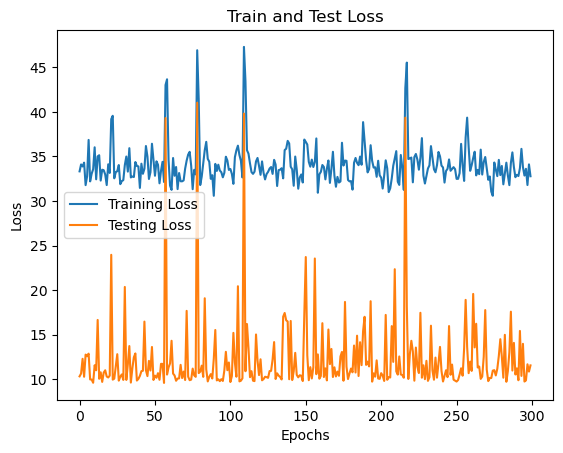

In [42]:
plt.title('Train and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.plot(epoch_nums, train_loss_hist, label='Training Loss')
plt.plot(epoch_nums, test_loss_hist, label='Testing Loss')
plt.legend()

In [43]:
with torch.no_grad():
    pred = model(x_test.float())[:, 0]
    loss = loss_fn(pred, y_test)
    print(f'Test MSE: {loss.item():.4f}')

Test MSE: 11.5576
